# Enter Dogs v Cat Redux

In [1]:
%bookmark lesson_home
%cd data/redux
%bookmark data_home
%cd -b data_home

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux
(bookmark:data_home) -> /home/ubuntu/workplace/deep_learning_course/lesson1/data/redux
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux


In [2]:
%cd -b lesson_home

(bookmark:lesson_home) -> /home/ubuntu/workplace/deep_learning_course/lesson1
/home/ubuntu/workplace/deep_learning_course/lesson1


In [104]:
import sys, os

#Allow relative imports
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from utils.utils import *
from utils.vgg16 import Vgg16

In [4]:
%matplotlib inline

#Set base directory to deep_learning_course repo
#%cd ~/workplace/deep_learning_course (cd into wherever the repo lives)
lesson_home = os.getcwd()
data_home = lesson_home + "/data/redux"
print lesson_home, data_home

/home/ubuntu/workplace/deep_learning_course/lesson1 /home/ubuntu/workplace/deep_learning_course/lesson1/data/redux


In [5]:
batch_size=64

To do:
1. create validation set and sample
2. move to separate dirs for each set
3. finetune and train
4. submit

## Create validation set and sample

In [6]:
#Create directories
%cd -b data_home
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir valid
%mkdir results
%mkdir -p test/unknown

#Bookmark directories
%cd train
%bookmark train
%cd ../test
%bookmark test
%cd ../valid
%bookmark valid
%cd ../results
%bookmark results
%cd ../sample/train
%bookmark sample_train
%cd ../test
%bookmark sample_test
%cd ../valid
%bookmark sample_valid

(bookmark:data_home) -> /home/ubuntu/workplace/deep_learning_course/lesson1/data/redux
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/train
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/test
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/valid
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/results
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/sample/train
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/sample/test
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/sample/valid


In [7]:
%cd -b train

(bookmark:train) -> /home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/train
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/train


In [8]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], data_home+'/valid/' + shuf[i])

In [9]:
from shutil import copyfile

In [10]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], data_home+'/sample/train/' + shuf[i])

In [11]:
%cd -b valid

(bookmark:valid) -> /home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/valid
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/valid


In [12]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], data_home+'/sample/valid/' + shuf[i])

## Move to separate dirs for each set

#### Run the following command in each of the train/valid directories

In [16]:
#cd to directory here 
%cd -b valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

(bookmark:valid) -> /home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/valid
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/valid


In [17]:
# Create single 'unknown' class for test set
%cd -b test
%mv *.jpg unknown/

(bookmark:test) -> /home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/test
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/test


## Finetune and train

In [80]:
%cd -b data_home
#Set path to sample path if desired
sample_path = data_home +'/sample/'
prod_path = data_home +'/'
path = sample_path

(bookmark:data_home) -> /home/ubuntu/workplace/deep_learning_course/lesson1/data/redux
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux


In [19]:
vgg = Vgg16()

In [20]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [21]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
200/200 [==============================] - 7s - loss: 1.6389 - acc: 0.7650 - val_loss: 0.3224 - val_acc: 0.9800


In [22]:
vgg.model.save_weights(path+'results/ft1.h5')

#### Run a few more epochs...

In [23]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
200/200 [==============================] - 7s - loss: 0.1612 - acc: 0.9900 - val_loss: 0.3224 - val_acc: 0.9800


In [24]:
vgg.model.save_weights(path+'results/ft2.h5')

In [25]:
vgg.model.optimizer.lr = 0.01

In [26]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
200/200 [==============================] - 7s - loss: 0.4030 - acc: 0.9750 - val_loss: 0.3224 - val_acc: 0.9800


In [27]:
vgg.model.save_weights(path+'results/ft2_1.h5')

In [28]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
200/200 [==============================] - 7s - loss: 0.3599 - acc: 0.9750 - val_loss: 0.9671 - val_acc: 0.9400


In [29]:
vgg.model.save_weights(path+'results/ft2_2.h5')

## Submit

In [30]:
batches, preds = vgg.test(prod_path+'/test', batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [33]:
filenames = batches.filenames

In [34]:
preds[:5]

array([[  1.0000e+00,   0.0000e+00],
       [  0.0000e+00,   1.0000e+00],
       [  1.0000e+00,   2.8340e-39],
       [  1.0000e+00,   0.0000e+00],
       [  0.0000e+00,   1.0000e+00]], dtype=float32)

In [35]:
filenames[:5]

['unknown/9292.jpg',
 'unknown/12026.jpg',
 'unknown/9688.jpg',
 'unknown/4392.jpg',
 'unknown/779.jpg']

In [36]:
save_array(path+'results/test_preds.dat', preds)
save_array(path+'results/filenames.dat', filenames)

In [38]:
preds = load_array(path+'results/test_preds.dat')
filenames = load_array(path+'results/filenames.dat')

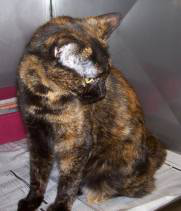

In [41]:
from PIL import Image
Image.open('test/'+filenames[2])

In [43]:
isdog = preds[:,1] #grab dogs column
isdog[:5]

array([  0.0000e+00,   1.0000e+00,   2.8340e-39,   0.0000e+00,   1.0000e+00], dtype=float32)

In [44]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9292, 12026, 9688, 4392, 779]

In [45]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   0.0000e+00],
       [  1.2026e+04,   1.0000e+00],
       [  9.6880e+03,   2.8340e-39],
       [  4.3920e+03,   0.0000e+00],
       [  7.7900e+02,   1.0000e+00]])

In [81]:
np.savetxt(prod_path+'subm98.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [82]:
%cd -b lesson_home
from IPython.display import FileLink
FileLink('data/redux/subm98.csv')

(bookmark:lesson_home) -> /home/ubuntu/workplace/deep_learning_course/lesson1
/home/ubuntu/workplace/deep_learning_course/lesson1


/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/subm98.csv

## Visualizing results

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [83]:
vgg.model.load_weights(path+'results/ft1.h5')

In [84]:
val_batches, probs = vgg.test(prod_path+'valid', batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [85]:
labels = val_batches.classes
filenames = val_batches.filenames

In [86]:
probs = probs[:,0]
preds = np.round(1-probs)
probs[:8]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [87]:
preds[:8]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [88]:
# Number of images to view for each visualization task
n_view = 4

Helper function to plot images by index in the validation set:

In [93]:
def plots_idx(idx, titles=None):
    plots([image.load_img(prod_path + 'valid/' + filenames[i]) for i in idx], titles=titles)

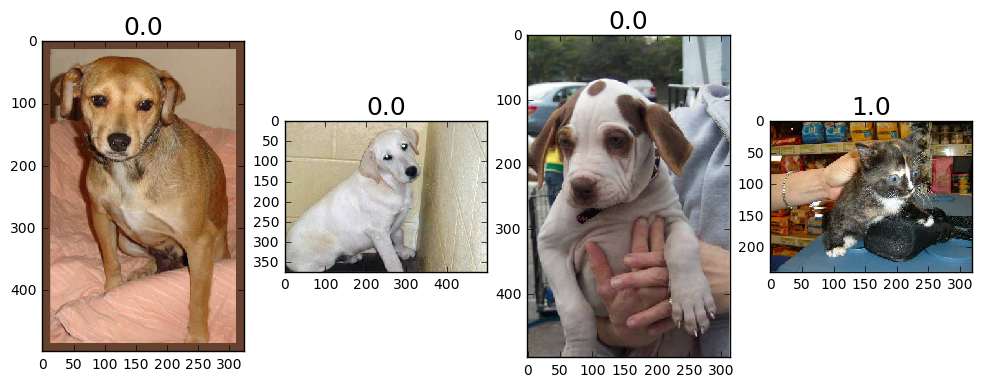

In [94]:
#1. A few correct labels at random
correct = np.where(preds==labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

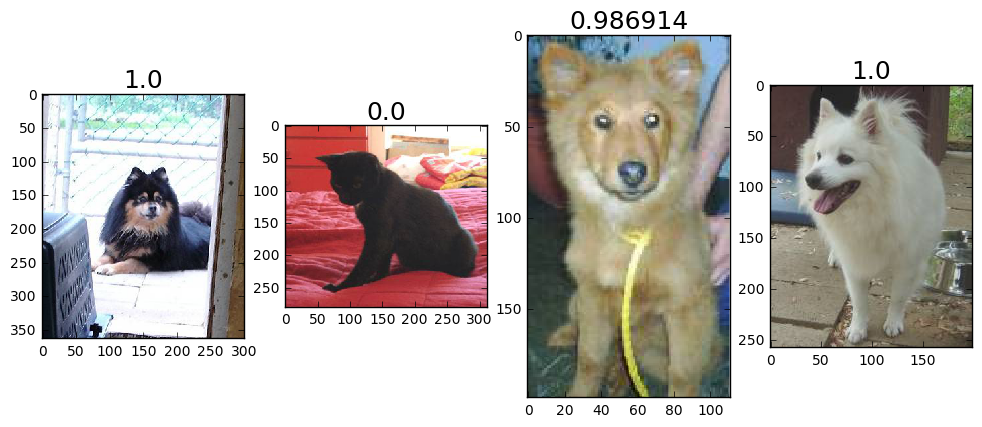

In [96]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=labels)[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

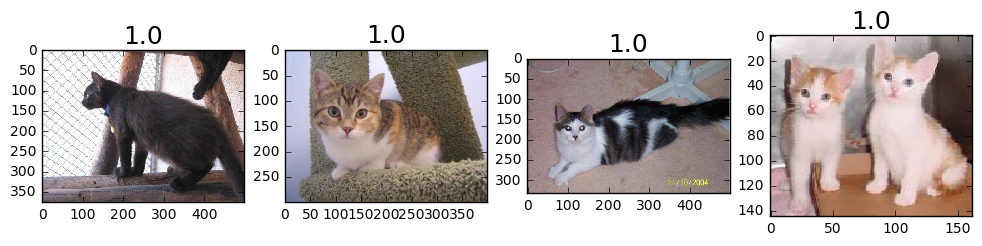

In [97]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==labels))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

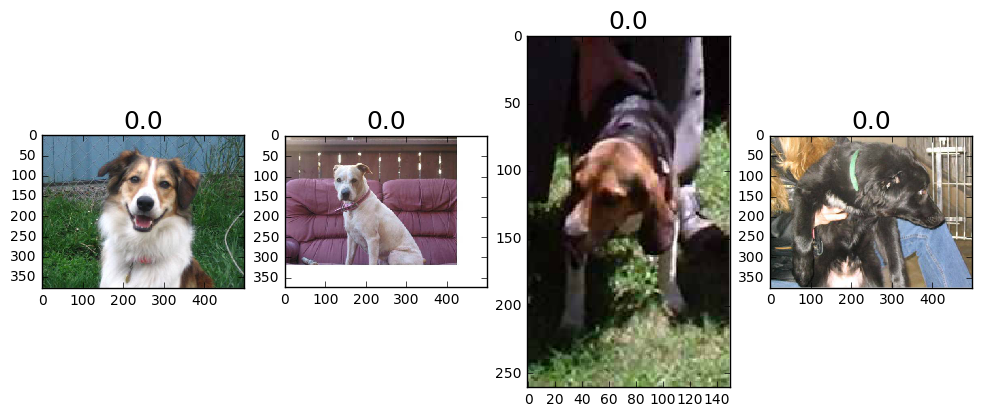

In [98]:
#3. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((preds==1) & (preds==labels))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs])

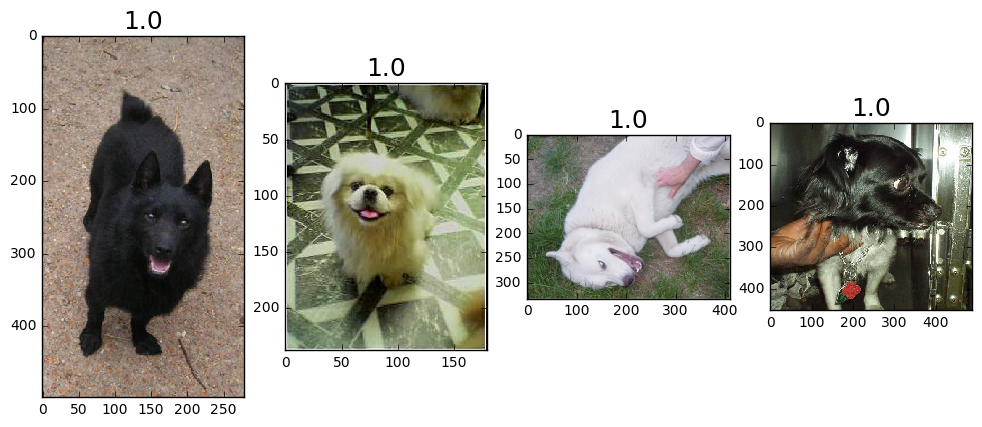

In [99]:
#3. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=labels))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

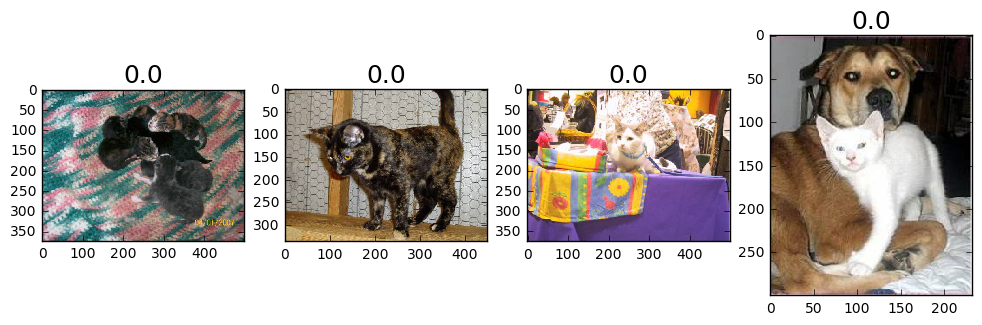

In [100]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=labels))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])

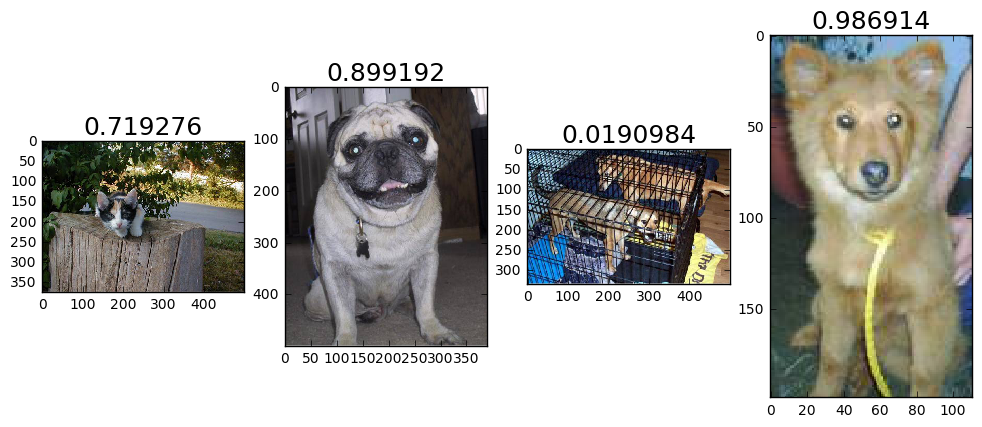

In [101]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [112]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[965  26]
 [ 33 976]]


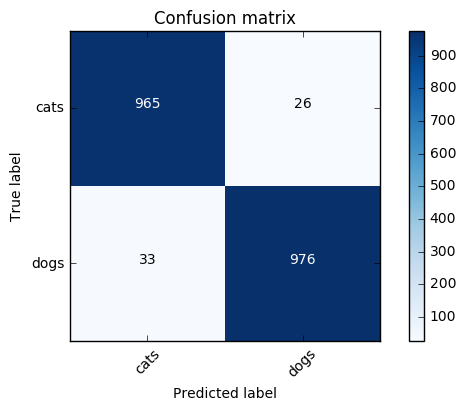

In [113]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [124]:
imgIds = subm[:,0]
isdog = np.clip(subm[:,1], 0.05, 0.95)
newsubmission = np.stack([imgIds,isdog], axis=1)
newsubmission[:5]

array([[  9.2920e+03,   5.0000e-02],
       [  1.2026e+04,   9.5000e-01],
       [  9.6880e+03,   5.0000e-02],
       [  4.3920e+03,   5.0000e-02],
       [  7.7900e+02,   9.5000e-01]])

In [127]:
np.savetxt(prod_path+'subm2.csv', newsubmission, fmt='%d,%.5f', header='id,label', comments='')

In [128]:
%cd -b lesson_home
FileLink('data/redux/subm2.csv')

(bookmark:lesson_home) -> /home/ubuntu/workplace/deep_learning_course/lesson1
/home/ubuntu/workplace/deep_learning_course/lesson1


/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/subm2.csv